# Convolutional Neural Networks
## Reviewing Neural Networks
Back when I was trying to predict all-NBA players, I did a simple feed-forward Neural Network in R using the neural net package. That package was pretty simple and allowed you to simply define how many hidden layers you wanted and how many nodes you wanted in each hidden layer. I won't get too into how a regular feed-forward neural network works again here, but essentially we are building linear combinations of sigmoid functions to create a potentially highly non-linear decision boundary:

<img src="https://s3.ca-central-1.amazonaws.com/2017edmfasatb/fas_boto/images/neuralnet/7neuralnetworksigmoid.png" style="width: 500px;"/>

When using a NN to perform image recognition, generally we take each pixel of the image as an input and we generate a NN with many inputs (just think if we had a simple 28 x 28 pixel image, we would have 784 inputs to our NN). Aside from the fact that a NN with more inputs takes more time to train, the image can easily shift... even if you're trying your hardest to recreate the image in the same way!

In reality, we _**can't expect**_ the image to come out the exact same way in the exact same pixels every time because we usually are training on real-world data.

## Convolutional Neural Networks
To continue our point in the last section, let's take a look at the classic _**MNIST**_ data set. The MNIST (Modified National Institute of Standards and Technology) dataset is a database of handwritten digits used for training image processing models. It includes ~55k training samples and ~10k test values, all consisting of 28 x 28 greyscale images of handwritten digits.

I say we can't expect the image to come out exactly the same way in the same pixels because, well, let's just look at these two digits below:

<img src="http://simonwinder.com/wp-content/uploads/2015/07/mnistExamples.png" style="width: 500px;"/>

If we pretend like each of these are its own 28 x 28 pixel image and visualize each pixel of each image as an input to the NN, we obviously will not have consistent inputs.

<img src="http://neuralnetworksanddeeplearning.com/images/mnist_complete_zero.png" style="width: 200px;"/>
<img src="http://rasbt.github.io/mlxtend/user_guide/data/mnist_data_files/mnist_data_10_0.png" style="width: 220px;"/>

Take these two zeroes for example. Sure, we can tell they're zeroes, but to a simple feed-forward NN, _**each pixel was is its own input, and therefore, they are independent of each other**_.

Going back to our all-NBA example, we had two inputs: WS and VORP. We could easily have thrown in more inputs as well: PTS, REB, AST, MP, WS48, DBPM... you name it... but the NN would look at these inputs as random variables that we're feeding it. In the case of image processing, _**contextual location matters**_.

Pixelized handwritten digits are obviously not independent in each pixel. A stroke of a pen / pencil / whatever writing utensil will have a width depending on the width of the utensil tip. This is evident as the second zero above is wider than the first. If we wanted to get REALLY REALLY nitpicky, _**the outer pixels of the second zero**_ will be 1's (representing a black pixel) whereas those same pixels would be 0's (representing a white pixel) on the first zero. This means that a feed-forward NN will view these input pixels and simply go "they're not the same". It has no context that the overall _**shape**_ of the images are very very similar.

In another example, let's look at 1's:

<img src="https://tensorflow.rstudio.com/images/MNIST-Matrix.png" style="width: 700px;"/>

The matrix representation is shown on the right (here, there are continuous values representing the darkness of the pixel rather than a binary 0 / 1, white / black representation, but the idea is the same). Let's say the 1 is moved five pixels to the left... The two input signals would be _**completely different**_. There literally would be no two pixels that are the same! From a feed-forward NN perspective, the inputs can vary so much that it wouldn't be too rigid of a training process.

_**Enter the convolutional NN.**_

<img src="https://68.media.tumblr.com/9af53b81b32f60b1cc5d028bc648cd29/tumblr_mtnvyzdj1k1si2z8ro1_500.gif" style="width: 500px;"/>

A convolutional NN uses the concepts of _**convolution**_ and _**max pooling**_ to simplify the image first before throwing it into a fully-connected layer and output layer.

I'd like to first throw out this video which I will be referencing for more or less the rest of this CNN intro. I obviously cannot take any of the credit for this video and just want to thank _**Brandon Rohrer**_ for creating this great video that I'm sure everyone and their mothers who are involved in CNNs have stumbled upon at this point. Upon checking his LinkedIn, it's clear that he likely knows what he's talking about as he has had certain [credentials](https://www.linkedin.com/in/brohrer/) since he was 18 that I will never have lol.

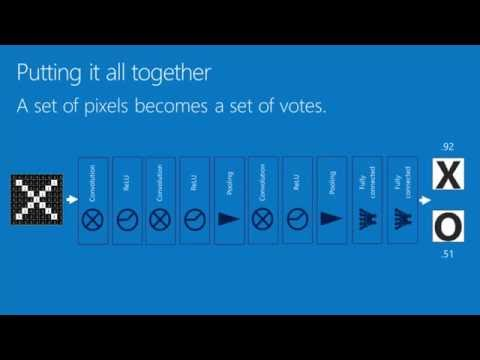

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('FmpDIaiMIeA')

Brandon begins by illustrating some of the points I was trying to make above. In his video, he tries to classify a 2D image that can either be an X or an O.

<img src="https://s3.ca-central-1.amazonaws.com/2017edmfasatb/chi_lars_face_detection/images/1_cnn.png" style="width: 250px;"/>

But, of course, we don't all write X's and O's the same way...

<img src="https://s3.ca-central-1.amazonaws.com/2017edmfasatb/chi_lars_face_detection/images/2_cnn_tricker_cases.png" style="width: 400px;"/>

We need to find a way to mitigate this variance because, again, a computer sees each pixel as an _**independent variable**_:

<img src="https://s3.ca-central-1.amazonaws.com/2017edmfasatb/chi_lars_face_detection/images/3_compare_x.png" style="width: 375px;"/>

<img src="https://s3.ca-central-1.amazonaws.com/2017edmfasatb/chi_lars_face_detection/images/4_pixel_compare_x.png" style="width: 130px;"/>

At this point, the video does a great job of explaining the convolution and max pooling concepts. Let's get into it.

## Convolution
Convolution is the process of using parts of the image to match and summarize the larger image. For example, if we localize our scope of the two X's above, we see that that the image is actually made of the same _**smaller pieces**_ and represent the same "idea" of an image, but obviously the smaller pieces are just shifted around a bit. In reality, we can think of many use cases that have this type of structural makeup... in our current objective, face detection, to some extent all humans have eyes, noses, a mouth... just shifted in different places on a face.

<img src="https://s3.ca-central-1.amazonaws.com/2017edmfasatb/chi_lars_face_detection/images/5_convolution_parts_of_image.png" style="width: 350px;"/>

We start convolution by using a set of filter banks _**that the algorithm actually finds itself**_. For this X example, the filter banks might look something like:

<img src="https://s3.ca-central-1.amazonaws.com/2017edmfasatb/chi_lars_face_detection/images/6_convolutional_filters.png" style="width: 350px;"/>

with the filters on either side representing the straight line strokes of the X and the filter in the middle representing the cross of the two strokes of the X.

The convolution algorithm goes as follows:
For each filter...
1. Line up the filter and image patch
2. Multiply each filter pixel by each image pixel (cross product)
3. Add them up
4. Divide by the total number of pixels
5. Represent the image patch with the total

Okay... that was a bit quick... let's take a closer look at these steps...

Let's say we're using the first filter to match parts of the image. Here, _**in step 1**_, we take the first filter and match it to a part of the image that matches up exactly:

<img src="https://s3.ca-central-1.amazonaws.com/2017edmfasatb/chi_lars_face_detection/images/7_filter_matching.png" style="width: 200px;"/>

In _**steps 2, 3, and 4**_, we essentially _**aggregate this entire patch matching process down to a single number as a result by using the dot product**_:

<img src="https://s3.ca-central-1.amazonaws.com/2017edmfasatb/chi_lars_face_detection/images/8_filter_matching_ex_1_1.png" style="width: 300px;"/>
<img src="https://s3.ca-central-1.amazonaws.com/2017edmfasatb/chi_lars_face_detection/images/9_filter_matching_ex_1_2.png" style="width: 300px;"/>
<img src="https://s3.ca-central-1.amazonaws.com/2017edmfasatb/chi_lars_face_detection/images/10_filter_matching_ex_1_3.png" style="width: 300px;"/>

In the first 3 images above, we are performing the dot product, that is, the pixelwise multiplication between the filter and the image. Below, we _**complete step 5**_ and use the result from the pixelwise multiplication and we sum and average into a single value to represent how the filter matched up at that point in the image.

<img src="https://s3.ca-central-1.amazonaws.com/2017edmfasatb/chi_lars_face_detection/images/11_convolution_ex_1_1.png" style="width: 400px;"/>

Taking a look at how the filter matches up in another area of the image...

<img src="https://s3.ca-central-1.amazonaws.com/2017edmfasatb/chi_lars_face_detection/images/13_convolution_ex_2_1.png" style="width: 400px;"/>

And completing the image...

<img src="https://s3.ca-central-1.amazonaws.com/2017edmfasatb/chi_lars_face_detection/images/14_finished_convolution_1_filter.png" style="width: 400px;"/>

And performing this process for all 3 filters available...

<img src="https://s3.ca-central-1.amazonaws.com/2017edmfasatb/chi_lars_face_detection/images/15_finished_convolution_3_filters.png" style="width: 400px;"/>

Notice that the filters representing diagonals are prominent along the axis of those diagonals, and the filter representing the cross is prominent at the center of the image... We are "generalizing" the larger image into these smaller features and _**we obtain a stack of results, 1 layer of the stack for each image**_.

At this point, our convolution step is done! Let's talk about max pooling.

## Max Pooling
Max pooling is a relatively easy concept. It's a step that
1. Minimizes the number of end-features and end-computations when we feed it into our feed-forward NN
2. Prevents overfitting by performing a type of averaging

Max pooling simply slides a window cross the image the represents that entire window by the maximum value found within that window. For example, the following situation uses a 2x2 pixel window sliding across our 7x7 convoluted image:
<img src="https://s3.ca-central-1.amazonaws.com/2017edmfasatb/chi_lars_face_detection/images/16_max_pooling_ex_1_1.png" style="width: 400px;"/>
<img src="https://s3.ca-central-1.amazonaws.com/2017edmfasatb/chi_lars_face_detection/images/17_max_pooling_ex_1_2.png" style="width: 400px;"/>
<img src="https://s3.ca-central-1.amazonaws.com/2017edmfasatb/chi_lars_face_detection/images/18_max_pooling_ex_1_3.png" style="width: 400px;"/>

Notice on that last one, the sliding window _**hangs off the image**_, one way to handle it as seen above is to simply only consider the pixels that are there, and consider all other pixels in the window non existent.

Completing the image...

<img src="https://s3.ca-central-1.amazonaws.com/2017edmfasatb/chi_lars_face_detection/images/19_max_pooling_ex_1_4.png" style="width: 400px;"/>

And pooling all 3 layers...

<img src="https://s3.ca-central-1.amazonaws.com/2017edmfasatb/chi_lars_face_detection/images/20_max_pooling_3_filters.png" style="width: 400px;"/>

Notice that, at the end of this pooling process, we have an image with fewer inputs that _**still represent an averaged pattern of our image**_!!

## Normalization
The final layer is the normalization layer. The normalization layer is also quite easy to grasp: it simply uses the _**Rectified Linear Unit**_ function (RELU) to zero out any negative values while keeping positive values:

<img src="https://s3.ca-central-1.amazonaws.com/2017edmfasatb/chi_lars_face_detection/images/21_relu.png" style="width: 300px;"/>

Applying the RELU function on a layer is simple:

<img src="https://s3.ca-central-1.amazonaws.com/2017edmfasatb/chi_lars_face_detection/images/22_relu_applied.png" style="width: 500px;"/>

What does this mean? It seems that the RELU layer often follows the convolution layer before max pooling. A negative value indicates that, in the convolution layer, a filter matched less than half of the sample from the image. If there were an equal number of pixels that matched and didn't match, we'd get a zero value. Therefore, we want to penalize filter matches which matched less than half of the pixels equally.

## Putting It All Together
Using these 3 tools (convolution, max pooling, normalization), we can combine the layers to continue shrinking and averaging our image down to a size that we are comfortable dealing with.

A simple CNN can look like this:
<img src="https://s3.ca-central-1.amazonaws.com/2017edmfasatb/chi_lars_face_detection/images/23_putting_it_all_together_1.png" style="width: 400px;"/>

A more complex CNN can look like this:
<img src="https://s3.ca-central-1.amazonaws.com/2017edmfasatb/chi_lars_face_detection/images/24_putting_it_all_together_2.png" style="width: 650px;"/>

## Fully Connected Layer
The last section of the CNN is a basic DNN. Each convoluted / averaged down stacks from the convoluted layers would act as inputs to a DNN. With this, we basically get a sense of how each of the filters contribute to the final classification task.

<img src="https://s3.ca-central-1.amazonaws.com/2017edmfasatb/chi_lars_face_detection/images/25_fully_connected_1.png" style="width: 100px;"/>

<img src="https://s3.ca-central-1.amazonaws.com/2017edmfasatb/chi_lars_face_detection/images/26_fully_connected_2.png" style="width: 250px;"/>

We can also build deep layers to end off our CNN.

<img src="https://s3.ca-central-1.amazonaws.com/2017edmfasatb/chi_lars_face_detection/images/27_fully_connected_3.png" style="width: 450px;"/>

## Final Network
Our final network can then look something like this:

<img src="https://s3.ca-central-1.amazonaws.com/2017edmfasatb/chi_lars_face_detection/images/28_final_network.png" style="width: 700px;"/>

Wow... that was a ride... well... that's a CNN! Let's explore TFlearn in the next post, a high-level abstraction to the popular NN python library, Tensorflow!